Counting train and test directory's length

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator

BASE_DIR = '/media/abelo/TERA/School/5to/IA/IA Project/fer2013'
TRAIN_DIR = os.path.join(BASE_DIR,'train')
TEST_DIR = os.path.join(BASE_DIR,'test')

total_train = 0
total_test = 0

for e in os.listdir(TRAIN_DIR):
    total_train +=  len(os.listdir(os.path.join(TRAIN_DIR,e)))

for e in os.listdir(TEST_DIR):
    total_test +=  len(os.listdir(os.path.join(TEST_DIR,e)))

print('train length:',total_train)
print('test length:',total_test)


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
train length: 28709
test length: 7178


Crear generador de imágenes. Nos permite configurar rápidamente
generadores de python que pueden convertir automáticamente archivos de imagen en el disco en
batches de tensores preprocesados.
flow_from_directory recibe:
- Directorio con imágenes.
- Cantidad de imágenes por batch.
- Rescalado de las imágenes.
- Determina el tipo de array de etiquetas a devolver. En este caso categorical porque usaremos sparse_categorical_crossentropy como nuestra función de pérdida.

In [2]:
# train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.20)

train_datagen = ImageDataGenerator(
validation_split=0.20,
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
) 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
TRAIN_DIR,
target_size=(150, 150),
batch_size=22,
subset='training',
class_mode='categorical')

valid_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode="categorical",
    subset='validation',
)

test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(150, 150),
    batch_size=37,
    class_mode="categorical"
)

train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
)


# train_generator = train_datagen.flow_from_directory(
# TRAIN_DIR,
# target_size=(150, 150),
# batch_size=22,
# class_mode='categorical',
# subset='training')

# valid_generator = train_datagen.flow_from_directory(
# TRAIN_DIR,
# target_size=(150, 150),
# batch_size=20,
# class_mode="categorical",
# subset='validation')


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


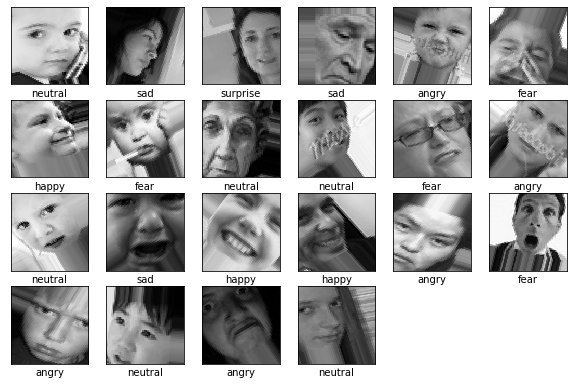

In [3]:
plt.figure(figsize=(10,10))
images_batch, labels_batch = train_generator.next()
print()
for i,p in enumerate(images_batch):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(p), cmap=plt.cm.binary)
    plt.xlabel(list(train_generator.class_indices.keys())[np.argmax(labels_batch[i])])


#### Building the model
En la siguiente sección se define la arquitectura de la red neuronal convolusional.
Para ello se colocan una serie de capas convolucionales 2d seguidas de capas maxpooling. El output de la última capa de convolución se aplana para obtner una entrada de una sola dimensión. Esta se pasa a una red neuronal encargada de determinar la emoción más probable dada una foto inicial.

In [8]:
from keras import layers
from keras import models
from keras import regularizers

def build_cnn_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))


    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))


    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))


    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(7, activation=tf.nn.softmax))

    return model

cnn_model = build_cnn_model()
print(cnn_model.summary())




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 36, 36, 64)       

#### Compilation process
Definimos la función de pérdida, el optimizador y las métricas como el learning rate; empleando la función compile.

In [5]:
from keras import optimizers
cnn_model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
            # optimizer= optimizers.Adam(learning_rate=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Train the model

In [7]:
history = cnn_model.fit(
        train_generator,
        batch_size = 22,
        epochs=10,
        validation_data=valid_generator,
        validation_steps=50)

Epoch 1/10
1044/1044 [==============================] - 257s 246ms/step - loss: 1.8128 - accuracy: 0.2495 - val_loss: 1.8576 - val_accuracy: 0.1600
Epoch 2/10
1044/1044 [==============================] - 110s 105ms/step - loss: 1.7968 - accuracy: 0.2499 - val_loss: 1.8415 - val_accuracy: 0.2340
Epoch 3/10
1044/1044 [==============================] - 110s 105ms/step - loss: 1.7928 - accuracy: 0.2509 - val_loss: 1.8347 - val_accuracy: 0.2250
Epoch 4/10
1044/1044 [==============================] - 108s 104ms/step - loss: 1.7905 - accuracy: 0.2511 - val_loss: 1.8281 - val_accuracy: 0.2500
Epoch 5/10
1044/1044 [==============================] - 109s 104ms/step - loss: 1.7889 - accuracy: 0.2526 - val_loss: 1.8339 - val_accuracy: 0.2470
Epoch 6/10
1044/1044 [==============================] - 107s 103ms/step - loss: 1.7871 - accuracy: 0.2528 - val_loss: 1.7975 - val_accuracy: 0.2670
Epoch 7/10
1044/1044 [==============================] - 109s 104ms/step - loss: 1.7870 - accuracy: 0.2535 - val_

#### Plot tranning process

In [53]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

KeyError: 'val_accuracy'

#### Test the model

In [54]:
score = cnn_model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

288/288 [==============================] - 12s 41ms/step - loss: 4.3133 - accuracy: 0.4374
Test loss: 4.313299655914307
Test accuracy: 0.43738025426864624
